<a href="https://colab.research.google.com/github/mahapara2411/devopsgit/blob/main/Customer_Targeting_%26_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import plotly
plotly.offline.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual,VBox,HBox,Layout
import ipywidgets as widgets

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Retail_Dataset.xlsx to Retail_Dataset.xlsx


In [3]:
df = pd.read_excel("Retail_Dataset.xlsx", sheet_name = ["Year 2009-2010", "Year 2010-2011"])

In [4]:
df1 = df["Year 2009-2010"]
df2 = df["Year 2010-2011"]

In [5]:
sum([df1.shape[0], df2.shape[0]])

1067371

In [6]:
data = df1.append(df2)

In [7]:
data.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  CustomerID         Country  
0 2009-12-01 07:45:00   6.95     13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75     13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75     13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10     13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25     13085.0  United Kingdom

In [11]:
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])
data['Sales'] = data.Quantity*data.Price
data['Year']=data.InvoiceDate.dt.year
data['Month']=data.InvoiceDate.dt.month
data['Week']=data.InvoiceDate.dt.isocalendar().week
data['Year_Month']=data.InvoiceDate.dt.to_period('M')
data['Hour']=data.InvoiceDate.dt.hour
data['Day']=data.InvoiceDate.dt.day
#data['is_cancelled']=data.Invoice.apply(lambda x: 'Yes' if x[0]=='C' else 'No')
data['weekday'] = data.InvoiceDate.dt.day_name()
data['Quarter'] = data.Month.apply(lambda m:'Q'+str(ceil(m/4)))
data['Date']=pd.to_datetime(data[['Year','Month','Day']])
data.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  CustomerID         Country  Sales  Year  Month  \
0 2009-12-01 07:45:00   6.95     13085.0  United Kingdom   83.4  2009     12   
1 2009-12-01 07:45:00   6.75     13085.0  United Kingdom   81.0  2009     12   
2 2009-12-01 07:45:00   6.75     13085.0  United Kingdom   81.0  2009     12   
3 2009-12-01 07:45:00   2.10     13085.0  United Kingdom  100.8  2009     12   
4 2009-12-01 07:45:00   1.25     13085.0  United Kingdom   30.0  2009     12   

   Week Year_Month  Hour  Day  weekday Quarter       Date  
0    49    2009-12     7    1  Tuesday      Q3 2009-12-01  
1    49    2009-12     7    1  Tuesday      Q3 2009-12-01  
2    49    2009-12     7    1  Tuesday      Q3 2009-12-01  
3    49    2009-12     7    1  Tuesday      Q3 2009-12-01  
4    49    2009-12     7    1  Tuesday      Q3 2009-12-01

**Missing Values**

In [12]:
missing_data = data.isnull().sum().reset_index()
missing_data.columns=['Variables','missing_count']
#missing_data['Missing_perc']
missing_data['missing_perc']=missing_data.missing_count/data.shape[0]
print(missing_data)
del missing_data

      Variables  missing_count  missing_perc
0       Invoice              0      0.000000
1     StockCode              0      0.000000
2   Description           4382      0.004105
3      Quantity              0      0.000000
4   InvoiceDate              0      0.000000
5         Price              0      0.000000
6    CustomerID         243007      0.227669
7       Country              0      0.000000
8         Sales              0      0.000000
9          Year              0      0.000000
10        Month              0      0.000000
11         Week              0      0.000000
12   Year_Month              0      0.000000
13         Hour              0      0.000000
14          Day              0      0.000000
15      weekday              0      0.000000
16      Quarter              0      0.000000
17         Date              0      0.000000


**Distribution of Unit and Quantity**

There are negative numbers under quantity hence sales are also negative. Negative number can be return transactions. Ideally, I should align each return with respective sales transaction and cancel out the entry. But for now, I will remove negative quantity for our further analysis.

In [14]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=data.Price),row=1, col=1)
fig.add_trace(go.Box(y=data.Quantity),row=1, col=2)
fig.add_trace(go.Box(y=data.Sales),row=1, col=3)

fig.update_xaxes(title_text="Unit Price", row=1, col=1)
fig.update_xaxes(title_text="Quantity", row=1, col=2)
fig.update_xaxes(title_text="Sales", row=1, col=3)

fig.update_layout(height=500, width=700)
fig.show()

**Geographical View**

In [15]:
df = px.data.gapminder()
df = df [['country','iso_alpha']]
data = pd.merge(data,df[['country','iso_alpha']],left_on='Country',right_on='country',how='left').drop(columns=['country'])
del df

In [16]:
grp_data = data.groupby(by='Country')['Sales'].sum().sort_values(ascending=False).reset_index()

fig = go.Figure(data=go.Choropleth(
    locations = grp_data['Country'],
    z = grp_data['Sales'],
    text = grp_data['Country'],
    colorscale = 'earth',
    locationmode = 'country names',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Sales',
))


fig.update_layout(
    title_text='Sales by country',
    geo=dict(showframe=False,showcoastlines=False,projection_type='equirectangular'),
    annotations = [dict(x=0.55,y=0.1,xref='paper',yref='paper',showarrow = False)])

fig.show()

del grp_data

Lets delete negative quantity from the data and proceed with further analysis

In [17]:
#data_=data[data.is_cancelled=='No']
#del data

AttributeError: ignored

**Ranking Trend**

Quarterly ranking all countries. This chart will show how quarterly ranking of each country is changing with respect sales.

Note: - I was looking for a way to connect each circle with line so that I could connect ranking circle of each country. This may help viewer to identify country and their ranking easily. Currently work is in progress for this section.

In [21]:
quarter_sales_country = data.pivot_table(index='Country', columns='Quarter', values='Sales',aggfunc='sum').fillna(0)
rank_data = quarter_sales_country.apply(lambda x: x.rank(method='dense').astype(int)).reset_index()
rank_data['idx']=rank_data.index
rank_data = rank_data.melt(id_vars=['Country','idx'])

fig = px.scatter(rank_data , y="Country", x='Quarter', color="Country", hover_data=['Country']
                 ,size='value')
#fig.data[0].update(mode='markers+lines')
fig.update_layout(height=1500,width=700)
fig.show(renderer="colab")

del [rank_data,quarter_sales_country]

**Daily Trend**

Due to presence of anomaly in the data, we can see some spike in the trend. There is no more detail available so it will be difficult to anticipate that this spike is due to any events or promotion. For now, lets assume that it is a random event.

In [22]:
sales_by_date = data.groupby(by='Date')['Sales'].sum().reset_index()
fig = go.Figure(data=go.Scatter(x=sales_by_date.Date,y=sales_by_date.Sales
                                ,line = dict(color='black', width=1.5)))
fig.update_layout(xaxis_title="Date",yaxis_title="Sales",title='Daily Sales',template='ggplot2')
fig.show(renderer="colab")

**Sales by Hours**

Hourly sales are normally distributed and with mean 709k.
There is no pattern in day wise sales in a month.
There is no business on Saturday.
Average sales are consistent from Monday to Friday
Sales starts at 6 in the morning and ends at 8 PM.
Peak hours of sales are between 10 AM to 3 PM
Monday and Tuesday Sales starts at 7 AM and close at 6 PM
Wednesday and Friday sales start at 7 AM and close at 8 PM
Business hours for Sunday is between 9 to 4 PM

In [24]:
sales_by_hour = data.groupby(by='Hour')['Sales'].sum().reset_index()
sales_by_weekday = data.groupby(by='weekday')['Sales'].sum().reset_index()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Total Hourly Sales", "Total Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show(renderer="colab")


del [sales_by_hour,sales_by_weekday]

In [25]:
customer_by_month1 = data.groupby('CustomerID')['Date'].min().reset_index()
customer_by_month1['days'] = pd.TimedeltaIndex(customer_by_month1.Date.dt.day,unit="D")
customer_by_month1['Month'] = customer_by_month1.Date- customer_by_month1.days+pd.DateOffset(days=1)
customer_by_month1['Quarter_acquisition'] = customer_by_month1['Month'].dt.quarter.apply(lambda x:'Q'+str(x))
customer_by_month1['Year_acquisition'] = customer_by_month1['Month'].dt.year
customer_by_month = data.groupby(by = customer_by_month1.Month)['CustomerID'].size().reset_index()
customer_by_month.sort_values(by ='Month',ascending=True,inplace=True)
customer_by_month['cum_customer'] = np.cumsum(customer_by_month.CustomerID)
customer_by_month['Month_1'] = customer_by_month['Month'].dt.strftime('%b-%y')

**Customer Acquisition Over Time**

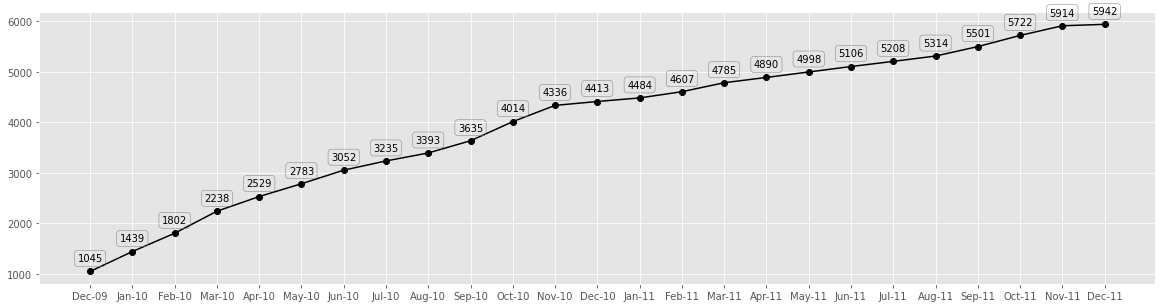

In [26]:
plt.style.use('ggplot')
plt.figure(figsize=(20,5))
plt.plot(customer_by_month.Month_1,customer_by_month.cum_customer,'bo-',color='black')

# zip joins x and y coordinates in pairs
for d,c in zip(customer_by_month['Month_1'],customer_by_month['cum_customer']):

    label = "{:.0f}".format(c)

    plt.annotate(label, 
                 (d,c), 
                 textcoords="offset points"
                 , bbox=dict(boxstyle="round", fc="none", ec="gray")
                 #,arrowprops=dict(arrowstyle="-",connectionstyle="angle,angleA=0,angleB=10,rad=90")
                 ,xytext=(0,10),
                 ha='center') 
plt.show()

del customer_by_month

Customer Acquisition vs Sales contribution

In [27]:
customer_sales = data.groupby(by = ['CustomerID','Year','Quarter'])['Sales'].sum().reset_index()
customer_sales = customer_sales.merge(customer_by_month1[['CustomerID','Quarter_acquisition','Year_acquisition']]
                                      ,on ='CustomerID',how='inner')
customer_sales_acquisition = customer_sales.groupby(by=['Year','Quarter','Year_acquisition','Quarter_acquisition'])['Sales'].sum().reset_index()
customer_sales_acquisition['Sales_Year_quarter'] =customer_sales_acquisition[['Year','Quarter']].apply(lambda row:str(row.Year)+'-'+row.Quarter,axis=1)
customer_sales_acquisition['Acquisition_Year_quarter'] =customer_sales_acquisition[['Year_acquisition','Quarter_acquisition']].apply(lambda row:str(row.Year_acquisition)+'-'+row.Quarter_acquisition,axis=1)
customer_sales_acquisition.drop(columns =['Year','Quarter','Year_acquisition','Quarter_acquisition'],inplace=True)
df = customer_sales_acquisition.pivot(index='Sales_Year_quarter',columns =['Acquisition_Year_quarter']).fillna(0).reset_index()


fig = go.Figure(data=[
    go.Bar(name='First Order 2010-Q4', x=df.Sales_Year_quarter, y=df.iloc[:,1],marker_color='lightslategrey'),
    go.Bar(name='First Order 2011-Q1', x=df.Sales_Year_quarter, y=df.iloc[:,2],marker_color='lightblue'),
    go.Bar(name='First Order 2011-Q2', x=df.Sales_Year_quarter, y=df.iloc[:,3],marker_color='seagreen'),
    go.Bar(name='First Order 2011-Q3', x=df.Sales_Year_quarter, y=df.iloc[:,4],marker_color='orange')
])
fig.update_layout(barmode='stack',template='ggplot2')
fig.show(renderer="colab")

del [customer_sales_acquisition, df,customer_sales]

**Repeat Purchases**

In [28]:
cust_date =data.loc[~data.CustomerID.isna(),['CustomerID','Date']].drop_duplicates()
cust_date.sort_values(by=['CustomerID','Date'],inplace=True)
cust_date['rnk'] = cust_date.groupby(by='CustomerID')['Date'].transform('rank', method='dense')
cust_date = cust_date[cust_date.rnk<=2]
cust_date['Purchase'] = cust_date.rnk.map({1:'First Purchase',2:'Second Purchase'})

cust_purchase= cust_date.pivot(index='CustomerID',columns=['Purchase'],values='Date').reset_index()

cust_purchase['gap']=(cust_purchase['Second Purchase']- cust_purchase['First Purchase'])/ np.timedelta64(30, 'D')
cust_purchase['gap'] = cust_purchase['gap'].fillna(0).apply(lambda x:ceil(x))

days = pd.TimedeltaIndex(cust_purchase['First Purchase'].dt.day,unit="D")

cust_purchase['First_Purchase_month']=cust_purchase['First Purchase']- days+pd.DateOffset(days=1)
cust_purchase_grid = cust_purchase.pivot_table(index=['First_Purchase_month'],columns =['gap'],values='CustomerID',aggfunc='count').fillna(0)
cust_purchase_grid = cust_purchase_grid.sort_index( ascending=False)

fig = go.Figure(data=go.Heatmap(z=cust_purchase_grid
                                ,y=cust_purchase_grid.index,
                   x=cust_purchase_grid.columns.tolist(),
                   hoverongaps = True,colorscale='balance'))
fig.update_xaxes(side="top",showticklabels = True,ticktext= cust_purchase_grid.columns.tolist())
fig.update_layout(height=600,width=800,xaxis_title="Future Month of next Purchase after making first purchase"
                  ,yaxis_title="Month of 1st Purchase",
           yaxis=dict(autorange='reversed',showticklabels = True)
                  ,autosize=False,template='ggplot2')

fig.show(renderer="colab")

del [cust_date,cust_purchase,days,cust_purchase_grid]

**Hypothetical Testing**

In [29]:
sales_by_hour = data.groupby(by='Hour')['Sales'].mean().reset_index()
sales_by_weekday = data.groupby(by='weekday')['Sales'].mean().reset_index()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Avg Hourly Sales", "Avg Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show(renderer="colab")

del [sales_by_hour,sales_by_weekday]

Hour

In [30]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
model = ols('Sales ~ C(Hour)',data=data).fit()
#ols.summary()
table = sm.stats.anova_lm(model, typ=2)
print(table)
del [table,model]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



                sum_sq          df           F  PR(>F)
C(Hour)   2.025421e+08        15.0  155.151241     0.0
Residual  1.092000e+12  12547406.0         NaN     NaN


Weekday

In [31]:
model = ols('Sales ~ C(weekday)',data=data).fit()
#moore_lm.summary()
table = sm.stats.anova_lm(model, typ=2)
print(table)

del [table,model]

                  sum_sq          df           F         PR(>F)
C(weekday)  5.320054e+07         6.0  101.867781  8.984078e-129
Residual    1.092150e+12  12547415.0         NaN            NaN


**LRFM**

In [36]:
LRFM = data.groupby('CustomerID').agg(Frequency=pd.NamedAgg(column="Invoice", aggfunc="nunique")
                                        ,Monetary=pd.NamedAgg(column="Sales", aggfunc="sum")).reset_index()

length = data.groupby('CustomerID')['Date'].max() - data.groupby('CustomerID')['Date'].min()
length =  (length/np.timedelta64(1, 'D')).reset_index()
length.columns = ['CustomerID','Length_of_stay']
LRFM = LRFM.merge(length,on='CustomerID',how='inner')
del length

LRFM.head()

CustomerID  Frequency  Monetary  Length_of_stay
0     12346.0         17   -776.16           400.0
1     12347.0          8  67599.84           402.0
2     12348.0          5  24232.80           363.0
3     12349.0          5  52854.48           717.0
4     12350.0          1   4012.80             0.0

**3 D View of Sales vs Length of Stay vs Frequency**

In [37]:
fig = go.Figure(data=[go.Scatter3d(x=LRFM.Monetary,y=LRFM.Length_of_stay,z=LRFM.Frequency,mode='markers'
                                   ,marker=dict(size=4,color='coral',colorscale='Viridis',opacity=0.8))])
fig.update_layout(margin=dict(l=1, r=2, b=1, t=1)
                  ,scene=dict(xaxis=dict(title='Sales')
                              ,yaxis=dict(title='Lenght of Stay')
                              ,zaxis=dict(title='Frequency')),width=800,height=500)
fig.show(renderer="colab")

**Segmentation**

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

In [39]:
X=LRFM.drop(columns = 'CustomerID')
error = []
silhouette = []
np.random.seed(12)
rng = range(2,20)
for i in rng:
    km = KMeans(n_clusters=i, init='random',n_init=20, max_iter=200,tol=.0001, random_state=12)
    km.fit(X)
    error.append(km.inertia_)
    lbls = km.fit_predict(X)
    silhouette.append(silhouette_score(X, lbls))

fig = make_subplots(rows=1, cols=2,subplot_titles=("Number of Cluster vs Error", "Number of Cluster vs Silhouette"))
fig.add_trace(go.Scatter(x=list(rng), y=error),row=1, col=1)
fig.add_trace(go.Scatter(x=list(rng), y=silhouette),row=1, col=2)
fig.update_layout(height=500, width=800,template='ggplot2')
fig.update_xaxes(title_text="Number of Clusters", row=1, col=1)
fig.update_xaxes(title_text="Number of Clusters", row=1, col=2)
fig.update_yaxes(title_text="Errors", row=1, col=1)
fig.update_yaxes(title_text="Silhouette Distance", row=1, col=2)
fig.show(renderer="colab")

del [error,silhouette,rng,km,lbls,X]

Create Clusters

In [40]:
X=LRFM.drop(columns = 'CustomerID')
cluster_lbls = KMeans(n_clusters=10, random_state=12).fit_predict(X)
X['cluster'] = cluster_lbls
X['sample_silhouette_values'] = silhouette_samples(X, cluster_lbls)
X['txt']=X.cluster.apply(lambda x:'Cluster '+str(x))

Silhoutee vs Sample

In [41]:
fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.sample_silhouette_values
                                , mode='markers',marker_color=X.cluster,text = X.txt))

fig.update_layout(xaxis_title="Sales",yaxis_title="Silhouette"
                  ,title='Sample Size vs Silhoutte Values')

fig.show(renderer="colab")

**Clustering Profile**

In [42]:
df = X.groupby('cluster').agg({'cluster':'size', 'Monetary':'mean','Frequency':'mean','Length_of_stay':'mean'}) \
       .rename(columns={'cluster':'Size','Monetary':'Avg Sales','Frequency':'Avg Recency','Length_of_stay':'Avg Lenght of Stay'}) \
       .reset_index().sort_values(by = 'Avg Sales')

cluster_map ={'Cluster 4':'lightskyblue','Cluster 0':'lightskyblue','Cluster 8':'lightskyblue'
              ,'Cluster 6':'lightskyblue','Cluster 2':'lightskyblue',
             'Cluster 3':'orange','Cluster 7':'orange','Cluster 9':'orange'
              ,'Cluster 1':'olive','Cluster 5':'olive'}

txt =['Size = {0:.0f}'.format(i) for i in df.Size]
df['cluster']=df.cluster.apply(lambda x:'Cluster '+str(x))
df['Group']=df.cluster.map(cluster_map)

fig = make_subplots(rows=1, cols=3,subplot_titles=("Avg Sales", "Avg Recency",'Avg Lenght of Stay'))

fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Sales'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Recency'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=2)
fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Lenght of Stay'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=3)

fig.update_traces(marker_line_color='rgb(8,48,107)', marker_line_width=1.5, opacity=0.8)
fig.update_layout(title_text='Cluster Size',width = 800,height=600,template='ggplot2'
                  ,font=dict(family="Courier New, monospace",size=10,color="RebeccaPurple"))

fig.show(renderer="colab")

  3D View of Clusters

In [43]:
fig = go.Figure(data=[go.Scatter3d(x=X.Monetary,y=X.Length_of_stay,z=X.Frequency,mode='markers'
                                   ,marker=dict(size=4,color=X.cluster
                                                ,colorscale='Viridis',opacity=0.8))])

# tight layout
fig.update_layout(margin=dict(l=1, r=2, b=1, t=1)
                  ,scene=dict(xaxis=dict(title='Sales')
                              ,yaxis=dict(title='Lenght of Stay')
                              ,zaxis=dict(title='Recency')),width=700,height=500)
fig.show(renderer="colab")

Bivariate view of by Segment

In [44]:
fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.Length_of_stay
                                , mode='markers',marker_color=X.cluster,text=X.txt))
fig.update_layout(xaxis_title="Sales",yaxis_title="Length of Stay",title='Sales vs Length of Stay'
                  ,width=800,height=500)
fig.show(renderer="colab")

In [45]:
fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.Frequency
                                , mode='markers',marker_color=X.cluster,text=X.txt))
fig.update_layout(xaxis_title="Sales",yaxis_title="Frequency",title='Sales vs Frequency'
                  ,width=800,height=500)
fig.show(renderer="colab")

**t-distributed Stochastic Neighbor Embedding**

In [46]:
prpxlt = [10,15,30,40]
fig = make_subplots(rows=2, cols=2,subplot_titles=['perplexity = %s'%i for i in prpxlt])

for i, prpxlt_ in enumerate(prpxlt):
    X_tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=prpxlt_).fit_transform(X[['Frequency', 'Monetary', 'Length_of_stay']])
    if i%2==0:
        c=2
    else:
        c=1
    r = (i)//2+1
    fig.add_trace(go.Scatter(x=X_tsne[:,0],y=X_tsne[:,1]
                                    , mode='markers',marker=dict(size=4,color=X.cluster
                                                ,colorscale='Viridis',opacity=0.8),text=X.txt),row=r, col=c)

    fig.update_xaxes(title_text="Component 1", row=r, col=c)
    fig.update_yaxes(title_text="Component 2", row=r, col=c)
    
fig.update_layout(height=600, width=800)
fig.show(renderer="colab")

del [X_tsne,fig]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

